Here, we examine functional sensitivity of the structure model on a small simulated dataset

In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, cavi_lib, plotting_utils
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp 
onp.random.seed(53453)

# Draw data

In [3]:
n_obs = 50
n_loci = 100
n_pop = 4

In [4]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

g_obs = np.array(g_obs)

Generating datapoints  0  to  50


Text(0.5, 0, 'individual')

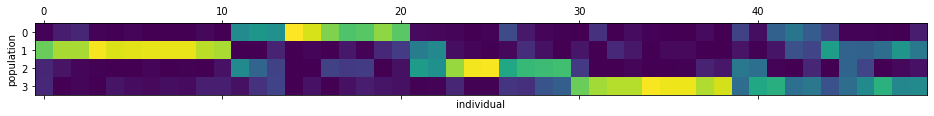

In [5]:
plt.matshow(true_ind_admix_propn.T)
plt.ylabel('population')
plt.xlabel('individual')

In [6]:
g_obs.shape

(50, 100, 3)

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


In [8]:
print(prior_params_dict)

{'dp_prior_alpha': DeviceArray([3.], dtype=float64), 'allele_prior_alpha': DeviceArray([1.], dtype=float64), 'allele_prior_beta': DeviceArray([1.], dtype=float64)}


# Get VB params 

In [9]:
k_approx = 12

In [10]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [11]:
use_logitnormal_sticks = True

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (100, 12, 2) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (50, 11) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (50, 11) (lb=0.0001, ub=inf)


## Initialize 

In [12]:
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                                seed = 412)

Text(0.5, 0, 'individual')

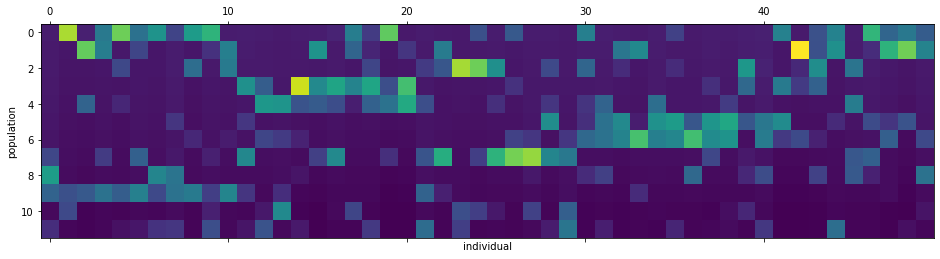

In [13]:
plt.matshow(plotting_utils.get_vb_expectations(vb_params_dict, gh_loc, gh_weights)[0].transpose())
plt.ylabel('population')
plt.xlabel('individual')

# Optimize

In [14]:
from vb_lib.structure_optimization_lib import define_structure_objective
from bnpmodeling_runjingdev.optimization_lib import run_lbfgs

In [15]:
optim_objective, init_vb_free = \
    define_structure_objective(g_obs, vb_params_dict,
                        vb_params_paragami,
                        prior_params_dict,
                        gh_loc = gh_loc,
                        gh_weights = gh_weights, 
                        compile_hvp=False)


Compiling objective ...
Iter 0: f = 24736.73403702
Compiling grad ...
Compile time: 13.7598secs


In [16]:
out = run_lbfgs(optim_objective, init_vb_free)

vb_opt = out.x
vb_opt_dict = vb_params_paragami.fold(vb_opt, free = True)



Running L-BFGS-B ... 
Iter 0: f = 24736.73403702
Iter 1: f = 24212.24771224
Iter 2: f = 22279.25067619
Iter 3: f = 13395.28862434
Iter 4: f = 11284.19601086
Iter 5: f = 9465.51542940
Iter 6: f = 8839.73687140
Iter 7: f = 8534.98787819
Iter 8: f = 8414.33320181
Iter 9: f = 8332.73361941
Iter 10: f = 8276.12788903
Iter 11: f = 8214.36824638
Iter 12: f = 8157.15615512
Iter 13: f = 8109.13835357
Iter 14: f = 8043.31754647
Iter 15: f = 8007.45961650
Iter 16: f = 7966.38937010
Iter 17: f = 7930.11321766
Iter 18: f = 7906.79158355
Iter 19: f = 7884.26972353
Iter 20: f = 7860.15420362
Iter 21: f = 7847.07830189
Iter 22: f = 7833.57188568
Iter 23: f = 7822.29281647
Iter 24: f = 7815.69771715
Iter 25: f = 7807.06442374
Iter 26: f = 7798.54155658
Iter 27: f = 7792.42944019
Iter 28: f = 7786.05027929
Iter 29: f = 7779.36362173
Iter 30: f = 7772.67196105
Iter 31: f = 7765.89897161
Iter 32: f = 7759.92786323
Iter 33: f = 7754.08883074
Iter 34: f = 7750.15411281
Iter 35: f = 7748.20992766
Iter 36: f

# Check out the fit

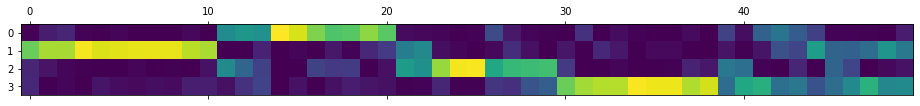

In [17]:
# truth
plt.matshow(true_ind_admix_propn.T)

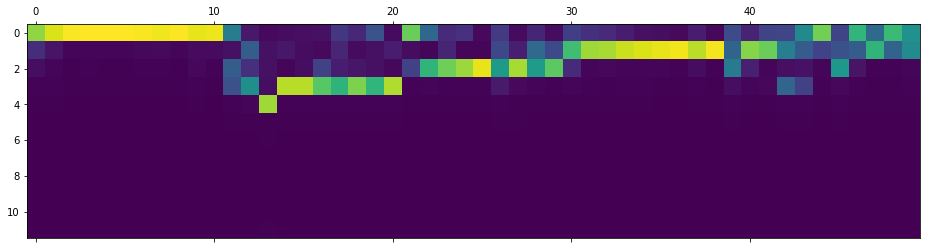

In [19]:
# fitted
e_ind_admix = plotting_utils.get_vb_expectations(vb_opt_dict, gh_loc, gh_weights)[0]
plt.matshow(e_ind_admix.T)

# Define prior perturbation

In [20]:
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib

In [21]:
def log_phi(logit_v):
    return(sp.special.expit(logit_v))

def phi(logit_v):
    return np.exp(log_phi(logit_v))

In [22]:
logit_v_grid = np.linspace(-8, 8, 200)

v_grid = np.exp(logit_v_grid) / (1 + np.exp(logit_v_grid))

print('phi max: ', np.max(phi(logit_v_grid)))
log_phi_max = np.max(np.abs(np.log(phi(logit_v_grid))))
print('log phi max: ', log_phi_max)

def rescaled_log_phi(logit_v):
    return 5 *  log_phi(logit_v) / log_phi_max


phi max:  2.717370405124736
log phi max:  0.9996646498695336


In [23]:
prior_perturbation = func_sens_lib.PriorPerturbation(
                                alpha0 = prior_params_dict['dp_prior_alpha'],
                                log_phi = rescaled_log_phi, 
                                logit_v_ub=8, logit_v_lb = -8)

print(
    prior_perturbation.log_norm_p0,
    prior_perturbation.log_norm_pc,
    prior_perturbation.log_norm_p0_logit,
    prior_perturbation.log_norm_pc_logit)


-1.0986122886681098 1.8311443398901506 -1.0996184973479006 1.8319892519619725


Text(0.5, 1.0, 'Priors in logit space')

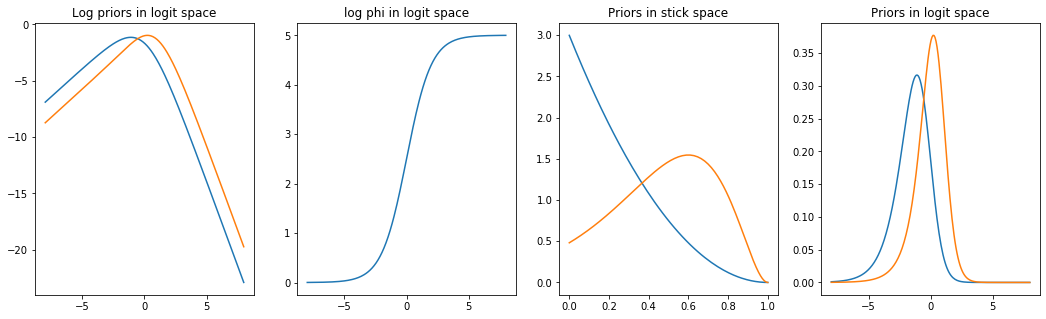

In [24]:
prior_perturbation.set_epsilon(1.0)

plt.figure(1, figsize=(18, 5))

plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, prior_perturbation.log_phi(logit_v_grid))
plt.title('log phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


In [25]:
log_prior_pert = lambda logit_v : rescaled_log_phi(logit_v) - prior_perturbation.log_norm_pc_logit

In [26]:
prior_perturbation.log_norm_pc_logit

DeviceArray(1.83198925, dtype=float64)

In [27]:
# we will use theses for the sensitivity class
get_epsilon_vb_loss = paragami.FlattenFunctionInput(
    lambda params, epsilon: structure_model_lib.get_kl(
                                                        g_obs, 
                                                        params,
                                                        prior_params_dict,
                                                        epsilon = epsilon,
                                                        gh_loc = gh_loc,
                                                        gh_weights = gh_weights,
                                                        log_phi = log_prior_pert,
                                                        ),
    argnums=0, patterns=vb_params_paragami, free=True)
    
def get_e_log_perturbation(log_phi, vb_params_dict, epsilon, gh_loc, gh_weights): 
    return func_sens_lib.get_e_log_perturbation(log_phi,
                            vb_params_dict['ind_admix_params']['stick_means'],
                            vb_params_dict['ind_admix_params']['stick_infos'],
                            epsilon, gh_loc, gh_weights, sum_vector=True)


hyper_par_objective_fun = paragami.FlattenFunctionInput(
    lambda params, epsilon: get_e_log_perturbation(log_prior_pert, 
                                                    params,
                                                    epsilon,
                                                    gh_loc, gh_weights),
    argnums=0, patterns=vb_params_paragami, free=True)

In [28]:
epsilon0 = np.array([0.])

In [29]:
# define preconditioner
cg_precond = lambda v : get_mfvb_cov_matmul(v, vb_opt_dict,
                                            vb_params_paragami,
                                            return_info = True)
t0 = time.time()
_ = cg_precond(vb_opt)
print('preconditioner time: {:0.3}sec'.format(time.time() - t0))

preconditioner time: 1.37sec


In [30]:
epsilon_sens = HyperparameterSensitivityLinearApproximation(get_epsilon_vb_loss,
                                                        vb_opt,
                                                        epsilon0, 
                                                        hyper_par_objective_fun = hyper_par_objective_fun, 
                                                        cg_precond=cg_precond)


Compiling hessian solver ...
Hessian solver compile time: 81.4011sec

Compiling cross hessian...
Cross-hessian compile time: 1.34551sec

LR sensitivity time: 0.805721sec



# Fit with perturbation

In [31]:
epsilon = 1.0
print('Epsilon: ', epsilon)

lr_vb_free_params = epsilon_sens.predict_opt_par_from_hyper_par(epsilon)

print('Predicted differences: ', np.linalg.norm(lr_vb_free_params - vb_opt))

Epsilon:  1.0
Predicted differences:  31.58498778020348


In [32]:
vb_pert_pred_dict = vb_params_paragami.fold(lr_vb_free_params, free = True)

In [33]:
new_init_dict = deepcopy(vb_opt_dict)
new_init_free = vb_params_paragami.flatten(new_init_dict, free = True)

In [34]:
optim_objective_pert, _ = \
    define_structure_objective(g_obs, new_init_dict,
                        vb_params_paragami,
                        prior_params_dict,
                        gh_loc = gh_loc,
                        gh_weights = gh_weights,
                        log_phi = log_prior_pert, 
                        epsilon = epsilon, 
                        compile_hvp=False)


Compiling objective ...
Iter 0: f = 7433.79796657
Compiling grad ...
Compile time: 12.9736secs


In [35]:
out = run_lbfgs(optim_objective_pert, new_init_free)

vb_opt_pert = out.x
vb_pert_dict = vb_params_paragami.fold(vb_opt_pert, free = True)


Running L-BFGS-B ... 
Iter 0: f = 7433.79796657
Iter 1: f = 7416.08530178
Iter 2: f = 7360.31339671
Iter 3: f = 7283.41486114
Iter 4: f = 7267.97888772
Iter 5: f = 7247.46325403
Iter 6: f = 7246.13648690
Iter 7: f = 7243.67361098
Iter 8: f = 7242.46173560
Iter 9: f = 7240.93466513
Iter 10: f = 7238.58219929
Iter 11: f = 7237.75982090
Iter 12: f = 7237.37548867
Iter 13: f = 7236.98876573
Iter 14: f = 7236.84120720
Iter 15: f = 7236.61778833
Iter 16: f = 7236.64848791
Iter 17: f = 7236.51874087
Iter 18: f = 7236.40456741
Iter 19: f = 7236.31071046
Iter 20: f = 7236.21694881
Iter 21: f = 7236.14292742
Iter 22: f = 7236.07774973
Iter 23: f = 7236.03484895
Iter 24: f = 7236.00987667
Iter 25: f = 7235.98665878
Iter 26: f = 7235.96907599
Iter 27: f = 7235.96097082
Iter 28: f = 7235.95160522
Iter 29: f = 7235.94733823
Iter 30: f = 7235.93671365
Iter 31: f = 7235.93053991
Iter 32: f = 7235.92284226
Iter 33: f = 7235.91207196
Iter 34: f = 7235.92580726
Iter 35: f = 7235.90837986
Iter 36: f = 72

In [36]:
np.linalg.norm(vb_opt_pert - vb_opt)

DeviceArray(25.49542812, dtype=float64)

### compare

In [37]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt): 
    plt.plot((lr_vb_free_params - vb_opt), 
             vb_opt_pert - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')


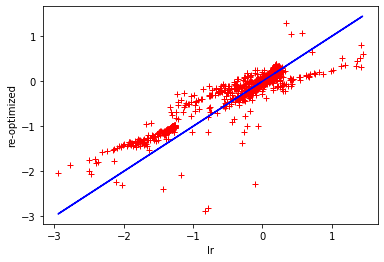

In [38]:
# compare free parameters
print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt)

In [39]:
# compare expectations
init_e_ind_admix, init_e_pop_freq = plotting_utils.get_vb_expectations(vb_opt_dict, gh_loc, gh_weights)
pert_e_ind_admix, pert_e_pop_freq = plotting_utils.get_vb_expectations(vb_pert_dict, gh_loc, gh_weights)
lr_e_ind_admix, lr_e_pop_freq = plotting_utils.get_vb_expectations(
                                                    vb_params_paragami.fold(lr_vb_free_params, free = True), 
                                                    gh_loc, gh_weights)

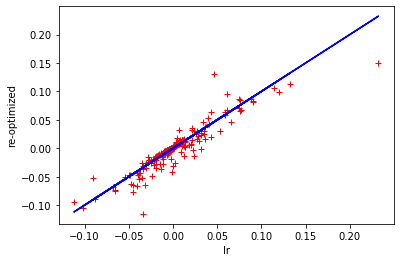

In [40]:
print_diff_plot(lr_e_ind_admix, pert_e_ind_admix, init_e_ind_admix)

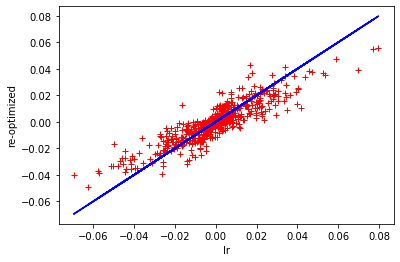

In [41]:
print_diff_plot(lr_e_pop_freq, pert_e_pop_freq, init_e_pop_freq)

In [42]:
print('init number of cluster: ', cluster_quantities_lib.get_e_num_clusters_from_ez(init_e_ind_admix))

print('pert number of cluster: ', cluster_quantities_lib.get_e_num_clusters_from_ez(pert_e_ind_admix))
print('lr number of cluster: ', cluster_quantities_lib.get_e_num_clusters_from_ez(lr_e_ind_admix))

init number of cluster:  5.577588359869459
pert number of cluster:  6.044130783860375
lr number of cluster:  5.6911500803824016


# Fit for a range of epsilon

In [44]:
epsilon_list = np.linspace(0, 1, 8) ** 2 # Square to get more points close to 0
print(epsilon_list)

[0.         0.02040816 0.08163265 0.18367347 0.32653061 0.51020408
 0.73469388 1.        ]


In [45]:
def refit_with_epsilon(epsilon, new_init_dict):
    # sets new epsilon, returns new vb optimum
    
    optim_objective_pert, new_init_free = \
        define_structure_objective(g_obs, new_init_dict,
                            vb_params_paragami,
                            prior_params_dict,
                            gh_loc = gh_loc,
                            gh_weights = gh_weights,
                            log_phi = log_prior_pert, 
                            epsilon = epsilon, 
                            compile_hvp=False)
    
    out = run_lbfgs(optim_objective_pert, new_init_free)
        
    return out.x


In [46]:
print('epsilons: ', epsilon_list)

epsilons:  [0.         0.02040816 0.08163265 0.18367347 0.32653061 0.51020408
 0.73469388 1.        ]


In [47]:
vb_pert_list = []
for epsilon in epsilon_list: 
    print('\n re-optimzing with epsilon = ', epsilon)
    
    vb_pert_list.append(refit_with_epsilon(epsilon, new_init_dict))



 re-optimzing with epsilon =  0.0
Compiling objective ...
Iter 0: f = 7551.80479680
Compiling grad ...
Compile time: 12.7022secs

Running L-BFGS-B ... 
Iter 0: f = 7551.80479680
Iter 1: f = 7553.88601523
Iter 2: f = 7551.80479229
done. Elapsed 0.175316secs
Iter 3: f = 7551.80479229
objective value:  7551.804792288652

 re-optimzing with epsilon =  0.02040816326530612
Compiling objective ...
Iter 0: f = 7549.39649414
Compiling grad ...
Compile time: 12.9256secs

Running L-BFGS-B ... 
Iter 0: f = 7549.39649414
Iter 1: f = 7549.67796477
Iter 2: f = 7549.34264582
Iter 3: f = 7549.32078048
Iter 4: f = 7549.30419307
Iter 5: f = 7549.30010406
Iter 6: f = 7549.29731387
Iter 7: f = 7549.29665668
Iter 8: f = 7549.29577172
Iter 9: f = 7549.29511239
Iter 10: f = 7549.29424768
Iter 11: f = 7549.29309228
Iter 12: f = 7549.29485639
Iter 13: f = 7549.29279403
Iter 14: f = 7549.29223970
Iter 15: f = 7549.29206672
Iter 16: f = 7549.29195310
Iter 17: f = 7549.29191200
Iter 18: f = 7549.29185531
Iter 19:

# Check free parameters

In [48]:
lr_list = []

for epsilon in epsilon_list: 
    
    # get linear response
    lr_list.append(epsilon_sens.predict_opt_par_from_hyper_par(epsilon))


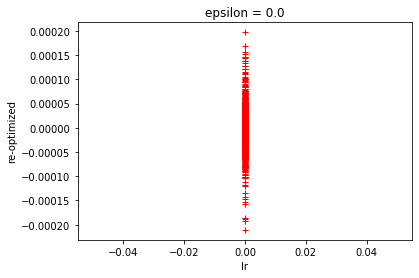

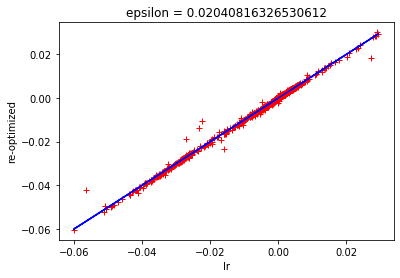

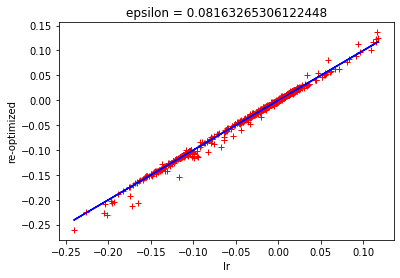

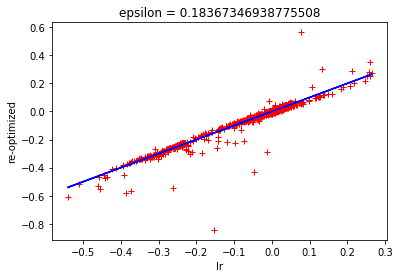

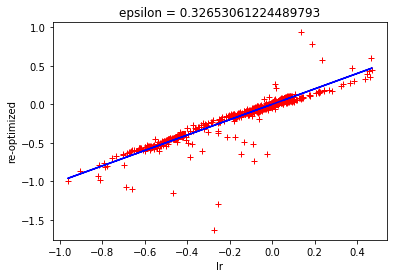

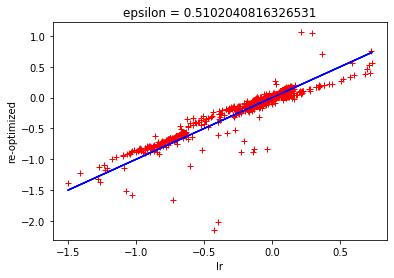

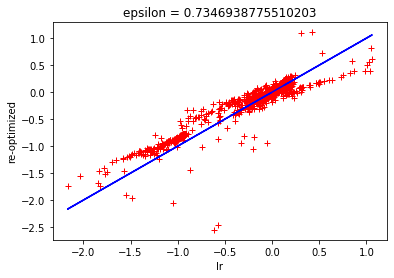

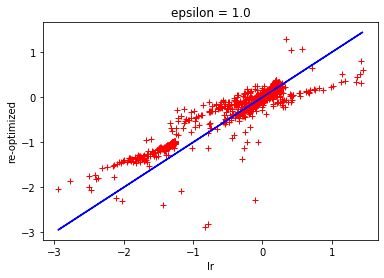

In [49]:
for i in range(len(epsilon_list)): 
    plt.figure()
    print_diff_plot(lr_list[i], vb_pert_list[i], vb_opt)
    
    plt.title('epsilon = {}'.format(epsilon_list[i]))


# Number of clusters

In [50]:
lr_e_num_clusters_vec = onp.zeros(len(epsilon_list))
refit_e_num_clusters_vec = onp.zeros(len(epsilon_list))

for i in range(len(epsilon_list)): 
    
    # get dictionaries
    pert_dict = vb_params_paragami.fold(vb_pert_list[i], free = True)
    lr_dict = vb_params_paragami.fold(lr_list[i], free = True)
    
    # get posterior expectations
    pert_e_ind_admix, pert_e_pop_freq = plotting_utils.get_vb_expectations(pert_dict, gh_loc, gh_weights)
    lr_e_ind_admix, lr_e_pop_freq = plotting_utils.get_vb_expectations(lr_dict, gh_loc, gh_weights)
    
    # get number of clusters
    refit_e_num_clusters_vec[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(pert_e_ind_admix)
    lr_e_num_clusters_vec[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(lr_e_ind_admix)


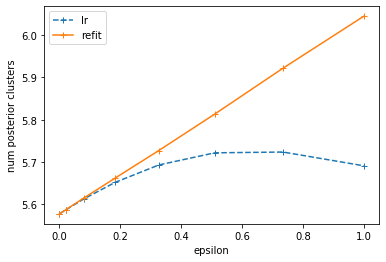

In [51]:
plt.plot(epsilon_list, lr_e_num_clusters_vec, '+--')
plt.plot(epsilon_list, refit_e_num_clusters_vec, '+-')

plt.xlabel('epsilon')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))
